## MILP tutorial 3 : add a time dimension

This tutorial requires a full understanding of the previous tutorials of the serie

In this tutorial, we add correlations to the time steps to simulate a storage. 

###   Create a MILP model with a time dimension and correlated time steps

This problem will be similar to the tutorial 2: we a variable load with time to provide from two different means: energy packages of 7MWh, or a continuous energy source.

The problem properties at each time step are the following:

-   0 MW <= Load(t) <= 20 MW
-   Prod1 :
    - package energy : 7MWh
    - price : 1€ / MWh
    - maximum packages count : 20
-   Prod2 :
    - maximum power : 15MW
    - price : 5€ / MW

Intuitively, we expect the production 1 to provide as many packages as possible, and provide the remaining load with the production 2.

In [21]:
# Import the Docplex Model object that manages the problem and its resolution
import math
import matplotlib.pyplot as plt
from docplex.mp.model import Model

model = Model()

We request here three variable lists:
- production 1 : count of package provided at each time step;
- production 2 : production of the second mean;
- package_available : count of package remaining (will decrement with production 1).

Note that even though the package_available will only store integers, it is suffisient to request continuous variables as they will only be subtracted integers. Integer variables are costly in term of computation time, so they must be avoided as much as possibe.

In [22]:
production_1 = model.integer_var_list(20, lb=0, ub=None, name="production_1")
production_2 = model.continuous_var_list(20, lb=0, ub=15, name="production_2")

package_available = model.continuous_var_list(20, lb=0, ub=None, name="package_available")

The load is here set to a sinusoidal value with time.

In [23]:
load = [15+5*math.sin(i/2) for i in range(20)]

The constraints can now be added at each time step:
- The productions equal the load;
- at the first time step, the packages available equals 20 (initial storage) - consumption at the first time step;
- later, the package available are decremented by the consumption.

The objective is incremented with the price of the production means at each time step.

In [24]:
objective = 0
for i in range(20):
    model += 7 * production_1[i] + production_2[i] == load[i]

    if i == 0:
        model += package_available[i] == 20 - production_1[i]
    else:
        model += package_available[i] == package_available[i-1] - production_1[i]

    objective += 1 * production_1[i] + 5 * production_2[i]

We can now provide the objective of the model that we are willing to minimize.

In [25]:
model.set_objective("min", objective)

For education purposes, it can be very informative to write down the model that the solver will read, it can be done using the command:

In [26]:
model.export_as_lp("my_multiple_milp_problem.lp")

'my_multiple_milp_problem.lp'

The problem can now be solved.

In [27]:
model.solve(log_output = True)

CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 21 rows and 41 columns.
Aggregator did 19 substitutions.
All rows and columns eliminated.
Presolve time = 0.02 sec. (0.07 ticks)

Root node processing (before b&c):
  Real time             =    0.02 sec. (0.08 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.02 sec. (0.08 ticks)


docplex.mp.solution.SolveSolution(obj=916.83,values={production_1_1:1,pr..

### Results plot

We can see that as expected, there is no remaining package at the end of the simulation as they are much cheaper than the production 2.

It is also important to note that the problem does not have a unique solution: the system could spend all of its packages as fast as possible, save the for the end or spend one per time step. Both solutions would have the same cost function. This issue appears in most problems with storage/production at the same cost. 

A way to close the multiple solutions issue would be to set a time dependant price: adding a very small increasing price to the packages would make the solver consume them as fast as possible as they are cheaper at the first time steps.

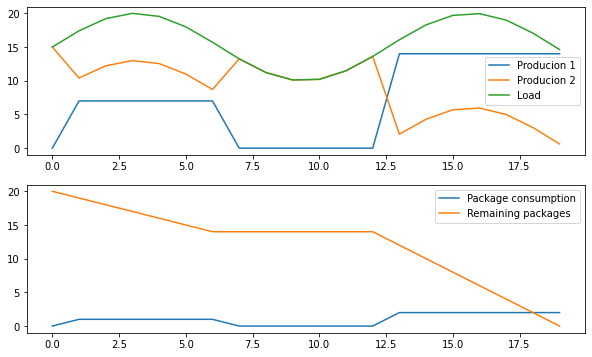

In [28]:
prod_1_solution = [7*val.solution_value for val in production_1]
prod_2_solution = [val.solution_value for val in production_2]

package_consumption_solution = [val.solution_value for val in production_1]
package_left_solution = [val.solution_value for val in package_available]

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(prod_1_solution, label = "Producion 1")
plt.plot(prod_2_solution, label = "Producion 2")
plt.plot(load, label = "Load")
plt.legend()

plt.subplot(2,1,2)
plt.plot(package_consumption_solution, label = "Package consumption")
plt.plot(package_left_solution, label = "Remaining packages")

plt.legend()
plt.show()